In [1]:
import sys

sys.path.append("/root/autodl-tmp/deeplabv3")
from datasets import DatasetSeq # (this needs to be imported before torch, because cv2 needs to be imported before torch for some reason)

sys.path.append("/root/autodl-tmp/deeplabv3/model")
from deeplabv3 import DeepLabV3

sys.path.append("/root/autodl-tmp/deeplabv3/utils")
from utils import label_img_to_color

import torch
import torch.utils.data
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import time

import os
############## import ipex ###############
import intel_extension_for_pytorch as ipex
##########################################

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


In [ ]:
batch_size = 1

network = DeepLabV3("eval_seq", project_dir="/root/autodl-tmp/deeplabv3")#.cuda()
network.load_state_dict(torch.load("/root/autodl-tmp/deeplabv3/pretrained_models/model_1_epoch_288.pth"))
############## TorchScript ###############
#optimizer = torch.optim.Adam(params = network.parameters(), lr=0.003)
network.eval()
network = ipex.optimize(model = network)
# network = torch.compile(network, backend="ipex")
##########################################


val_dirs = ["frankfurt/", "munster/", "lindau/"]
test_dirs = ["berlin/", "bielefeld/", "bonn/", "leverkusen/", "mainz/", "munich/"]


In [ ]:
Time = []
for sequence in val_dirs:
    print (sequence)

    val_dataset = DatasetSeq(cityscapes_data_path="/root/autodl-tmp/deeplabv3/data/cityscapes",
                            cityscapes_meta_path="/root/autodl-tmp/deeplabv3/data/cityscapes/meta",
                            sequence=sequence)

    num_val_batches = int(len(val_dataset)/batch_size)
    print ("num_val_batches:", num_val_batches)

    val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                            batch_size=batch_size, shuffle=False,
                                            num_workers=1)

    network.eval() # (set in evaluation mode, this affects BatchNorm and dropout)

    unsorted_img_ids = []
    for step, (imgs, img_ids) in enumerate(val_loader):
        with torch.no_grad(): # (corresponds to setting volatile=True in all variables, this is done during inference to reduce memory consumption)
            imgs = Variable(imgs)#.cuda() # (shape: (batch_size, 3, img_h, img_w))

            start_time = time.time()
            #outputs = network(imgs) # (shape: (batch_size, num_classes, img_h, img_w))
            ##########################################
            with torch.no_grad() and torch.cpu.amp.autocast():
                network(imgs)# (shape: (batch_size, num_classes, img_h, img_w))
            ##########################################
            end_time = time.time()
            elapsed_time = end_time - start_time
            Time.append(elapsed_time)

            Time = np.array(Time)
            print(Time)
            print(f"Avg Predict Time: {Time.sum()/len(Time)} secs")
            return

Avg Predict Time: 0.0032307310573390273


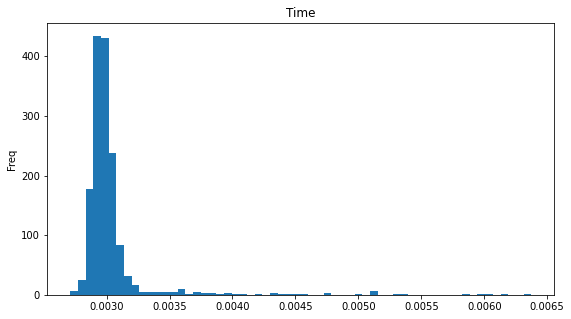

In [6]:
file_path_ = "/root/autodl-tmp/deeplabv3/Time.npy"
if os.path.exists(file_path_):
    Time = np.load('Time.npy')        
    print("Avg Predict Time:", Time.sum()/len(Time))
    for i in range(len(Time)):
        if(Time[i]>0.01):
            Time[i]=0.003
    plt.figure(figsize=(20, 5)) 
    plt.subplot(1, 2, 1)
    plt.hist(Time, bins=60)
    plt.ylabel("Freq")
    plt.title("Time")
    plt.show()